_Note: To execute code in this repository, you will need to install the `niwaves` package from GitHub:_

https://github.com/rciric/niwaves

# Task discriminability with lagged correlations

#### Rastko Ciric<sup>1</sup>

<sup>1</sup>, Department of Bioengineering, Stanford University

The timed performance of a psychological task can, in theory, be used as a means of perturbing the connectome and mapping the dynamic repertoire of transient functional configurations accessible to the brain<sup>1</sup>. In particular, deploying different tasks to constrain brain activation yields both task-specific updates to the connectome and task-general changes that are shared across multiple tasks<sup>2</sup>. Spatial patterns of task-related activation, much like functional connectivity, are subject-specific; indeed, it is possible to use a subject's resting functional connectivity to estimate the spatial extent of brain activation in response to a particular task<sup>3</sup>. Furthermore, previous work suggests that task-related variance is secondary to individual differences in the connectome: a greater amount of connectomic variability is attributable to stable individual differences than to task-driven reconfiguration<sup>4</sup>.

The overwhelming preponderance of prior studies of lagged correlation have made use of task-unconstrained data. Here, I again use the Midnight Scan Club dataset<sup>5</sup>, this time to tentatively investigate (1) whether different tasks mediate predictable changes in lag structure and (2) whether) task-related changes in lag systems capture more or less variance than individual differences in lag structure. I hypothesise that, as is the case for functional connectivity, lag variance will be dominated by individual differences rather than task-related reconfiguration.

In [1]:
import glob
import niwaves
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

### Sample characteristics

As previously, begin by loading the data.

* Repetition time/sampling time is 2.2 s.
* Data have been processed using a 36-parameter denoising model<sup>6</sup>.
* Mean time series have been extracted from each node of the 400-region version of the Schaefer parcellation<sup>7</sup>.
* A well-characterised 7-network community structure is used to sort the data<sup>8</sup>.
* Four tasks are considered here: rest, motor, memory, and lexical. The analysis combines across three different incidental memory tasks.
* The task time series has not been included in the confound regression step here; ideally, the analysis should be repeated both with and without removal of the task time series (but see<sup>9</sup>).
* To run lag analysis for each task in turn, we use the `lag_analysis` function in `niwaves`, providing as an argument a temporal mask indicating whether each time point is relatively free of motion artefact; frames flagged for high motion are not considered in lag estimates.

In [2]:
subjects = ['sub-MSC{:02}'.format(i) for i in range(1,11)]
sessions = ['ses-func{:02}'.format(i) for i in range(1,11)]
tasks = ['task-rest',
         'task-motor',
         'task-memory*',
         'task-glasslexical']
runs = ['run-01',
        'run-02']
ts = {
      task: {
       sub: {
        ses: {
         run: {'roi': glob.glob('data/MSC/ts/{}_{}_{}_run-*_schaefer400_ts.1D'.format(sub, ses, task)),
          'motion': glob.glob('data/MSC/motion/{}_{}_{}_run-*_relRMS.1D'.format(sub, ses, task))
         } for run in runs
        } for ses in sessions
       } for sub in subjects
      } for task in tasks
     }

In [3]:
community = pd.read_table('data/network/schaefer400x7CommunityAffiliation.1D', header=None)

In [4]:
# All tasks this time
ts_data = {}
ts_motion = {}
lags = {}
peaks = {}
tmask = {}
for task in tasks:
    lags[task] = {}
    peaks[task] = {}
    tmask[task] = {}
    if task in ['task-motor', 'task-glasslexical']:
        runs = ['run-01', 'run-02']
    else:
        runs = ['run-01']
    for sub in subjects:
        lags[task][sub] = {}
        peaks[task][sub] = {}
        tmask[task][sub] = {}
        ts_data = []
        ts_motion = []
        for ses in sessions:
            try:
                for run in runs:
                    ts_data.append(pd.read_csv(ts[task][sub][ses][run]['roi'][0],
                                               sep=' ', header=None))
                    ts_motion.append(pd.read_csv(ts[task][sub][ses][run]['motion'][0],
                                                 sep=' ', header=None))

            except IndexError:
                pass
            ts_c = reduce(lambda x, y: pd.concat([x, y]), ts_data)
            ts_mo_c = reduce(lambda x, y: pd.concat([x, y]), ts_motion)
            tmask[task][sub] = ts_mo_c < 0.2
            lags[task][sub], peaks[task][sub] = niwaves.lag_analysis(timeseries1=ts_c.values,
                                                                                   tmask=tmask[task][sub].values,
                                                                                   sample_time=2.2,
                                                                                   min_block=10,
                                                                                   lagmax=3)

As some subjects may be missing runs, I include a try/catch block.

In [5]:
groupr = {}
for i, sub in enumerate(subjects):
    for task in tasks:
        for j, ses in enumerate(sessions):
            try:
                groupr[(sub, task)] = lags[task][sub].ravel()
            except KeyError:
                pass
groupr = pd.DataFrame(groupr)

Let's examine the task-specific lag matrices. Results for the 4 tasks are displayed in order below: rest, then motor, then memory, and finally lexical/Glass patterns.

/home/vagrant/miniconda3/envs/py3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


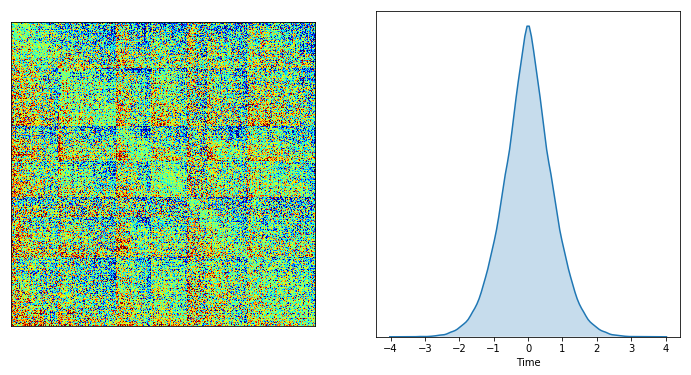

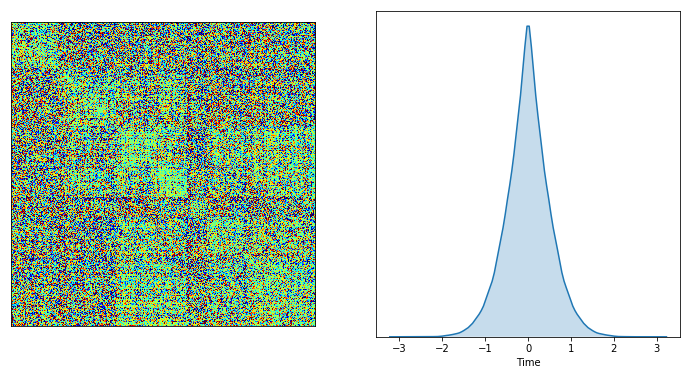

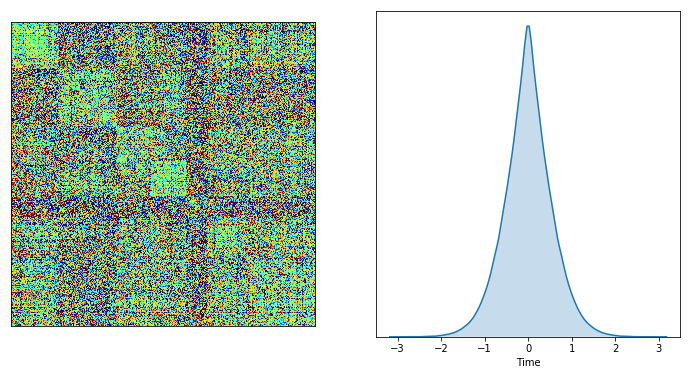

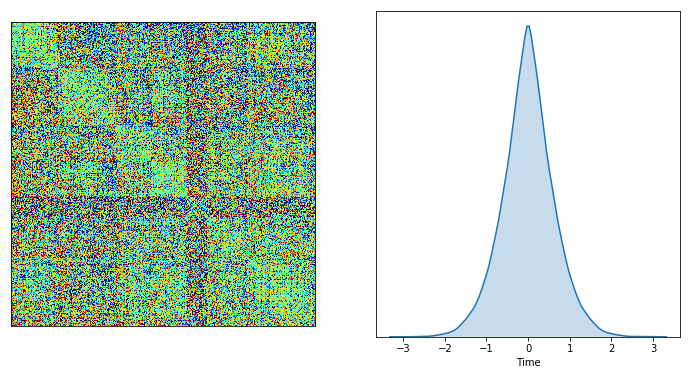

In [12]:
niwaves.lag_sort(groupr.iloc[:, groupr.columns.get_level_values(1)=='task-rest'].mean(axis=1).values.reshape(400,400),
                 community, vrange=[-1.5, 1.5])
niwaves.lag_sort(groupr.iloc[:, groupr.columns.get_level_values(1)=='task-motor'].mean(axis=1).values.reshape(400,400),
                 community, vrange=[-0.8, 0.8])
niwaves.lag_sort(groupr.iloc[:, groupr.columns.get_level_values(1)=='task-memory*'].mean(axis=1).values.reshape(400,400),
                 community, vrange=[-0.8, 0.8])
niwaves.lag_sort(groupr.iloc[:, groupr.columns.get_level_values(1)=='task-glasslexical'].mean(axis=1).values.reshape(400,400),
                 community, vrange=[-1, 1])

Interestingly, we note two principal ways in which non-resting lags differ from resting lags:

* Lags at rest appear to be more ordered, while task-constrained lags generally look noisier. However, the three mean task-constrained lag patterns appear superficially similar to one another. Under task constraint, within-network lags are markedly closer to zero than between-network lags.
* Under task constraint, the distribution of lags in general clusters more tightly around zero. There are multiple possible reasons for this, which future investigation might disambiguate. For instance, it's possible that task-constrained lag estimates are not generally reproducible across subjects (with the current level of sampling) and consequently average closer to 0. Alternatively, it's possible that, in the absence of task regression, task-related activity has synchronised many time series.

In general, I'm suspicious of the task-related lags presented here, as they don't much resemble any previous reports of lagged correlation structure. Task-constrained lags rely on substantially less data than resting lags, and it's possible that the volume of data is insufficient to produce a result approaching stability. Alternatively, it's possible that suboptimal preprocessing is strongly impacting lag estimates.

To get a sense of connectomic differences associated with task activation, we next plot the peak correlation matrix for each task in order: rest, motor, memory, and lexical/Glass pattern.

In [16]:
grouprpk = {}
for i, sub in enumerate(subjects):
    for task in tasks:
        for j, ses in enumerate(sessions):
            try:
                pks = peaks[task][sub]
                pks[np.diag_indices_from(pks)] = 0
                grouprpk[(sub, task)] = pks.ravel()
            except KeyError:
                pass
grouprpk = pd.DataFrame(grouprpk)

/home/vagrant/miniconda3/envs/py3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


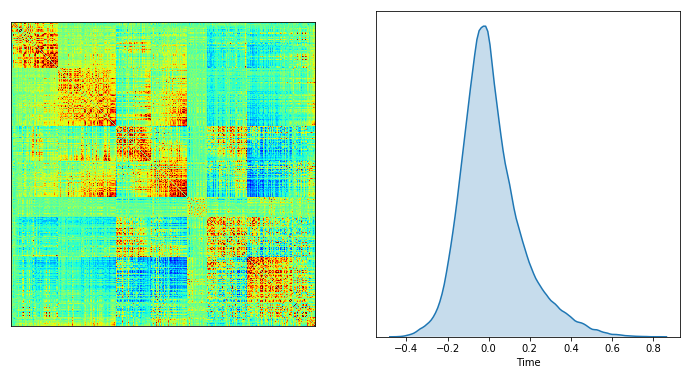

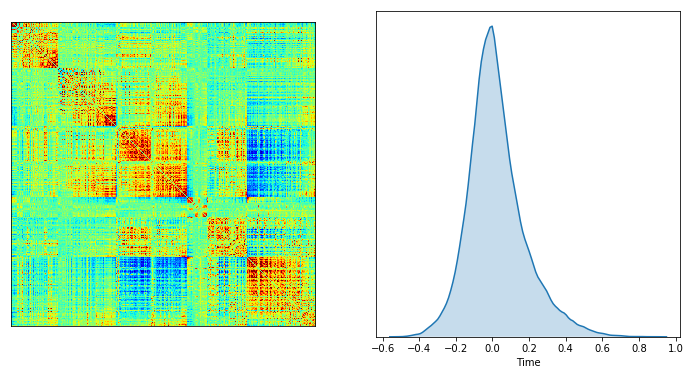

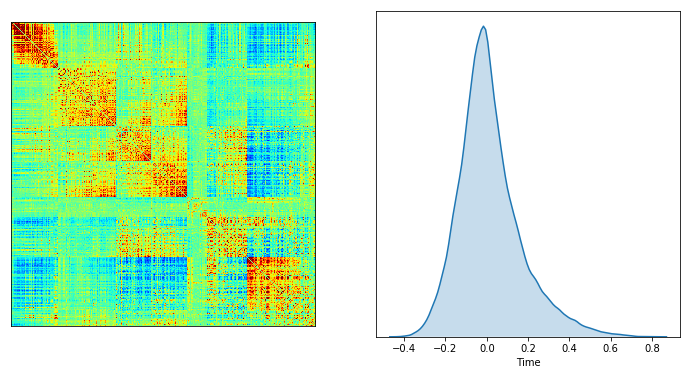

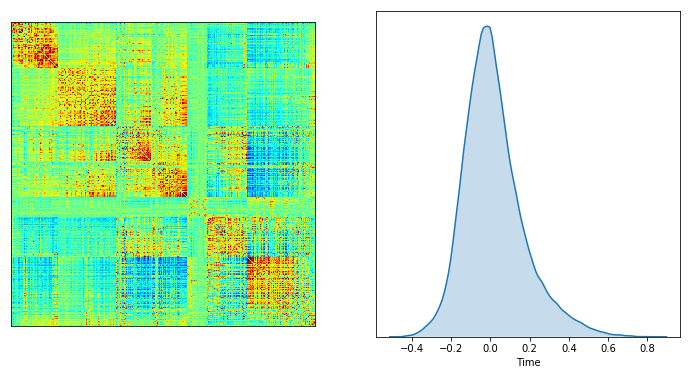

In [17]:
niwaves.lag_sort(grouprpk.iloc[:, grouprpk.columns.get_level_values(1)=='task-rest'].mean(axis=1).values.reshape(400,400),
                 community, vrange=[-0.55, 0.55])
niwaves.lag_sort(grouprpk.iloc[:, grouprpk.columns.get_level_values(1)=='task-motor'].mean(axis=1).values.reshape(400,400),
                 community, vrange=[-0.55, 0.55])
niwaves.lag_sort(grouprpk.iloc[:, grouprpk.columns.get_level_values(1)=='task-memory*'].mean(axis=1).values.reshape(400,400),
                 community, vrange=[-0.55, 0.55])
niwaves.lag_sort(grouprpk.iloc[:, grouprpk.columns.get_level_values(1)=='task-glasslexical'].mean(axis=1).values.reshape(400,400),
                 community, vrange=[-0.55, 0.55])

The matrices in general appear to exhibit more commonalities than differences, although some differences are noteworthy. For instance, motor task performance generally appears to restructure the somatomotor network (second block along the diagonal) while elevating the coupling between dorsal and ventral attention subsystems (third and fourth blocks, respectively) and parts of the somatomotor network. In the future, it could be interesting to evaluate whether peak correlation matrices exhibit more or less similarity to one another across tasks in comparison with zero-lag correlation matrices.

Next, let's see whether variation between subjects or variation between tasks dominates variance in lag estimates. To do this, we'll create a feature-wise similarity matrix similar to the ones we previously looked at to investigate subject discriminability. Once again, bold white lines delineate the 10 subjects. The fainter lines in this case separate different tasks: rest, motor, memory, and lexical/Glass in order within each subject, colour-coded as blue, teal, orange, and red in the second colour bar at left. Because of the high noise inherent in these lag measures, similarities are weak across the board, and the range of the colourmap is restricted between _r = 0.01_ and _r = 0.04_: these are by no means strong effects. Given my general lack of confidence in the task-constrained lag structures presented above and their substantial divergence from previously reported lag structures, I strongly caution against placing stock in these results before a more thorough analysis can be conducted.

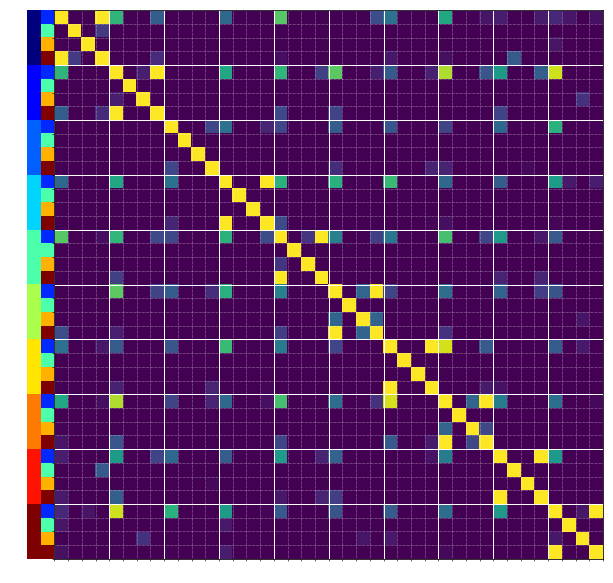

In [18]:
niwaves.simil_plot(groupr.corr(), 4, [0.01, 0.04])

First, we remark the stunning lack of similarity between subject-specific lags estimated during performance of motor and memory tasks (second and third rows/columns within each subject block) and all other lag patterns. Second, the strongest relationships generally exist within subjects, between each subject's resting lag pattern and the same subject's lag pattern during lexical/Glass task performance. Third, there also generally exists a weakly positive relationship between the lags estimated for different subjects at rest (top left square within each 4-by-4 block of the larger subject-level grid). While there is some convergence with the analogous results from zero-lag functional connectivity analysis -- there is generally greater similarity between rest and lexical/Glass lags within subjects than there is between different subjects' resting and lexical/Glass lags -- I hesitate to lend any particular interpretation to this result in light of the noisy nature of these measures and my current lack of confidence in their validity .

### References

1. Gonzalez-Castillo J, Hoy CW, Handwerker DA, Robinson ME, Buchanan LC, Saad ZS, Bandettini PA (2015) Tracking ongoing cognition in individuals using brief, whole-brain functional connectivity patterns. Proc Natl Acad Sci U S A 112(28):8762-7.

2. Cole MW, Bassett DS, Power JD, Braver TS, Petersen SE (2014) Intrinsic and task-evoked network architectures of the human brain. Neuron 83(1):238-51.

3. Tavor I, Parker Jones O, Mars RB, Smith SM, Behrens TE, Jbabdi S (2016) Task-free MRI predicts individual differences in brain activity during task performance. Science 352(6282):216-20.

4. Gratton C, Laumann TO, Nielsen AN, Greene DJ, Gordon EM, Gilmore AW, Nelson SM, Coalson RS, Snyder AZ, Schlaggar BL, Dosenbach NUF, Petersen SE (2018) Neuron Apr 18;98(2):439-452.e5.

5. Gordon EM, Laumann TO, Gilmore AW, Newbold DJ, Greene DJ, Berg JJ, Ortega M, Hoyt-Drazen C, Gratton C, Sun H, Hampton JM, Coalson RS, Nguyen AL, McDermott KB, Shimony JS, Snyder AZ, Schlaggar BL, Petersen SE, Nelson SM, Dosenbach NUF (2017) Precision Functional Mapping of Individual Human Brains. Neuron 95(4):791-807.e7.

6. Satterthwaite TD, Elliott MA, Gerraty RT, Ruparel K, Loughead J, Calkins ME, Eickhoff SB, Hakonarson H, Gur RC, Gur RE, Wolf DH (2013) An improved framework for confound regression and filtering for control of motion artifact in the preprocessing of resting-state functional connectivity data. Neuroimage 64:240-56.

7. Schaefer A, Kong R, Gordon EM, Laumann TO, Zuo XN, Holmes AJ, Eickhoff SB, Yeo BTT (2018) Local-Global Parcellation of the Human Cerebral Cortex from Intrinsic Functional Connectivity MRI. Cereb Cortex 28(9):3095-3114.

8. Yeo BT, Krienen FM, Sepulcre J, Sabuncu MR, Lashkari D, Hollinshead M, Roffman JL, Smoller JW, Zöllei L, Polimeni JR, Fischl B, Liu H, Buckner RL (2011) The organization of the human cerebral cortex estimated by intrinsic functional connectivity. J Neurophysiol 106(3):1125-65.

9. Cole MW, Ito T, Schultz D, Mill R, Chen R, Cocuzza C (2018) Task activations produce spurious but systematic inflation of task functional connectivity estimates. Biorxiv preprint.